In [991]:
import warnings
warnings.simplefilter(action='ignore')

In [992]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans
from scipy.stats.mstats import winsorize  # nan_policy does not work
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB

from supporting_funcs import *
import pickle
import os

In [1064]:
fname = './data/data.csv'
df = pd.read_csv(fname)
df.drop(['Loan_ID'], axis=1, inplace=True)

In [1065]:
# SETTING CLASS WEIGHTS
# wj=n_samples / (n_classes * n_samplesj)
# wj is the weight for each class(j signifies the class)
n_samples = df.shape[0]                             # n_samples is the total number of samples or rows in the dataset
n_classes = 2                                       # n_classes is the total number of unique classes in the target
n_sample1 = df[df['Loan_Status'] == 'Y'].shape[0]     # n_samplesj is the total number of rows of the respective class
n_sample2 = df[df['Loan_Status'] == 'N'].shape[0]

In [1066]:
weight1 = n_samples / (n_classes * n_sample1)
weight2 = n_samples / (n_classes * n_sample2)

### Modeling

### First Approach

In [1067]:
cat_feats = df.columns[df.dtypes == 'object'].tolist()
num_feats = df.columns[df.dtypes != 'object'].tolist()

In [1068]:
df['CoapplicantIncome'] = np.where(df['CoapplicantIncome'] == 0, np.nan, df['CoapplicantIncome'])

In [1069]:
na_indices = {cat: df[df[cat].isna()].index.tolist() for cat in cat_feats}

In [1070]:
dummies = pd.get_dummies(df[cat_feats])

In [1071]:
dm_cols = dummies.columns[dummies.dtypes != 'object'].tolist()
dm_map = {}
for feat in cat_feats:
    dm_map[feat] = []
    for col in dm_cols:
        if col.startswith(feat):
            dm_map[feat].append(col)

In [1072]:
for feat, col_names in dm_map.items():
    for col_name in col_names:
        dummies[col_name].iloc[na_indices[feat]] = np.nan

In [1073]:
df = pd.concat([df[num_feats], dummies], axis=1)

In [1074]:
# sns.swarmplot(data=df, x='CoapplicantIncome')
# plt.show()
# sns.swarmplot(data=df, x='ApplicantIncome')
# plt.show()
df['ApplicantIncome'] = winsorize_pandas(df['ApplicantIncome'], limits=(0, 0.1))
df['CoapplicantIncome'] = winsorize_pandas(df['CoapplicantIncome'], limits=(0, 0.1))
# sns.swarmplot(data=df, x='CoapplicantIncome')
# plt.show()
# sns.swarmplot(data=df, x='ApplicantIncome')
#############################################
# sns.swarmplot(data=df, x='LoanAmount')
# plt.show()
df['LoanAmount'] = winsorize_pandas(df['LoanAmount'], limits=(0, 0.05))
# sns.swarmplot(data=df, x='LoanAmount')v

In [1075]:
knn = KNNImputer(n_neighbors=3)

In [1076]:
df = pd.DataFrame(knn.fit_transform(df), columns=df.columns)

In [1077]:
df['CombinedIncome'] = np.log(df['ApplicantIncome'] + df['CoapplicantIncome'])
df['LoanAmount'] = np.log(df['LoanAmount'])
df['Loan_Amount_Term'] = df['Loan_Amount_Term'] / 12

In [1078]:
df.drop(['ApplicantIncome', 'CoapplicantIncome'], axis=1, inplace=True)

In [1079]:
y = df['Loan_Status_Y']
df = df.drop(['Loan_Status_Y', 'Loan_Status_N'], axis=1)

In [1081]:
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=4, stratify=y, train_size=0.7)

In [1113]:
params = [
    {
        'C': [0.09],
        'class_weight': [{0:x, 1:1-x} for x in np.linspace(0.2, 0.8, 150)],
        'intercept_scaling': [0.1],
        'max_iter': [10000],
        'penalty': ['l1'],
        'solver': ['newton-cg', 'liblinear', 'saga'],

    }
]
grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=params, cv=StratifiedKFold(), scoring='f1', verbose=0, n_jobs=-1)

In [1114]:
grid_search.estimator.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [1115]:
grid_search.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/regular/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/regular/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/regular/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.09],
                          'class_weight': [{0: 0.2, 1: 0.8},
                                           {0: 0.20402684563758391,
                                            1: 0.7959731543624161},
                                           {0: 0.2080536912751678,
                                            1: 0.7919463087248322},
                                           {0: 0.2120805369127517,
                                            1: 0.7879194630872484},
                                           {0: 0.21610738255033557,
                                            1: 0.7838926174496644},
                                           {...
                                           {0: 0.30067114093959735,
                                            1: 0.6993288590604027},
                                       

In [1117]:
grid_search.best_params_

{'C': 0.09,
 'class_weight': {0: 0.6630872483221477, 1: 0.3369127516778523},
 'intercept_scaling': 0.1,
 'max_iter': 10000,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [1118]:
print('Train Data f1', metrics.f1_score(y_train, grid_search.predict(X_train)))
print('Test Data f1', metrics.f1_score(y_test, grid_search.predict(X_test)))

Train Data f1 0.8683812405446293
Test Data f1 0.8928571428571429


In [1096]:
print(metrics.classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.94      0.52      0.67        58
         1.0       0.82      0.98      0.89       127

    accuracy                           0.84       185
   macro avg       0.88      0.75      0.78       185
weighted avg       0.85      0.84      0.82       185



In [1097]:
# grid_search.predict_proba(X_test)

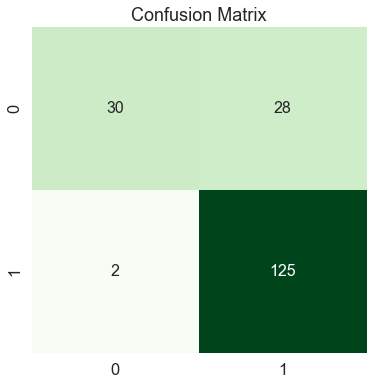

In [1098]:
conf_matrix(metrics.confusion_matrix(y_test, grid_search.predict(X_test)))

# Second Approach

In [1046]:
df = pd.read_csv(fname)
df = df.drop(['Loan_ID'], axis=1)

In [1050]:
y = df['Loan_Status']
df = df.drop(['Loan_Status',], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=4, stratify=y, train_size=0.7)

In [1051]:
lbl_enc = LabelEncoder()
y_test = lbl_enc.fit_transform(y_test)
y_train = lbl_enc.fit_transform(y_train)

In [1052]:
def pipe(df_):
    df_ = pd.get_dummies(df_, drop_first=True)
    imputed = KNNImputer(n_neighbors=3)
    dft_impu = imputed.fit_transform(df_)
    df_ = pd.DataFrame(dft_impu, columns=df_.columns.tolist())
    df_['LoanAmount'] = np.log(df_['LoanAmount'])
    df_['Combined_Income'] = df_['ApplicantIncome'] + df_['CoapplicantIncome']
    df_ = df_.drop(['ApplicantIncome', 'CoapplicantIncome'], axis=1)
    df_['Combined_Income'] = np.log(df_['Combined_Income'])
    df_['Loan_Amount_Term'] = df_['Loan_Amount_Term'] / 12
    return df_

In [1053]:
X_train = pipe(X_train)
X_test = pipe(X_test)

In [1054]:
params = [
    {
        'C': [0.07, 0.08, 0.09, 0.1],
        'class_weight': [{0:x, 1:1-x} for x in np.linspace(0.2, 0.8, 100)],
        'intercept_scaling': [0.1],
        'max_iter': [100],
        'penalty': ['l1'],
        'solver': ['newton-cg', 'liblinear'],
        # 'lib1_ratio': [0.1, 0.4, 0.9]
    }
]
grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=params, cv=StratifiedKFold(), scoring='f1', verbose=0, n_jobs=-1)

In [1055]:
grid_search.estimator.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [1056]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.07, 0.08, 0.09, 0.1],
                          'class_weight': [{0: 0.2, 1: 0.8},
                                           {0: 0.20606060606060608,
                                            1: 0.793939393939394},
                                           {0: 0.21212121212121213,
                                            1: 0.7878787878787878},
                                           {0: 0.2181818181818182,
                                            1: 0.7818181818181817},
                                           {0: 0.22424242424242424,
                                            1: 0.77575...
                                            1: 0.6545454545454545},
                                           {0: 0.35151515151515156,
                                            1: 0.6484848484848484},
            

In [1057]:
grid_search.best_params_

{'C': 0.09,
 'class_weight': {0: 0.6666666666666667, 1: 0.33333333333333326},
 'intercept_scaling': 0.1,
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [1058]:
print('F1 Score is :', grid_search.score(X_test, y_test))

F1 Score is : 0.900709219858156


In [1059]:
probas = pd.Series(grid_search.predict_proba(X_test)[:, 1])
pred = grid_search.predict(X_test)
adj_prob = np.where(probas <= 0.56, 0, 1)

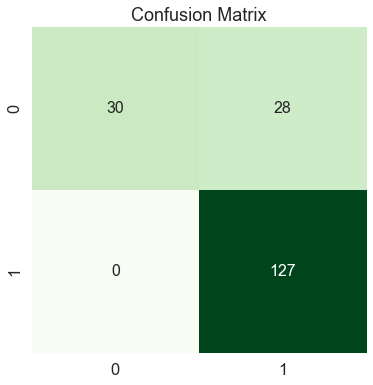

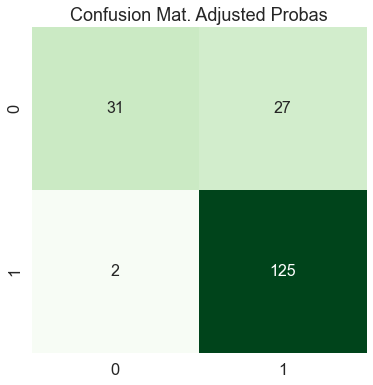

In [1062]:
conf_matrix(metrics.confusion_matrix(y_test, pred))
conf_matrix(metrics.confusion_matrix(y_test, adj_prob), title='Confusion Mat. Adjusted Probas')

<AxesSubplot:>

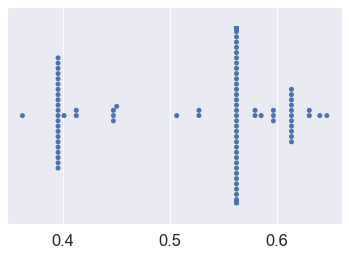

In [1063]:
sns.swarmplot(probas)